## DISCLAMER
Albeit stated in the title, getting an 100% accuracy should not be the end-goal of any real-world data science project. If your model scores a 100% accuracy, most probably you are overfitting or you have a data leakage on your hands. As the modern proverb goes, “If it seems too good to be true, it probably is.”

The main purpose of this notebook is to train myself various data wrangling techniques in order to get the best possible result fairly following best data science practices. At the same time, I hope this notebook would be deemed useful by the community especially for newcomers to start their data science journey. 

Constructive criticism are most welcome!

### Solution inspired by these amazing people:
- [MANAV SEHGAL](https://www.kaggle.com/code/startupsci/titanic-data-science-solutions/notebook)
- [GUNES EVITAN](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial/notebook)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# data analysis and wrangling
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Read files and have a glimpse of the data

In [3]:
train = pd.read_csv("../data/titanic_train.csv")
test = pd.read_csv("../data/titanic_test.csv")
combine = [train, test]
print('Number of rows (Train): ' + str(len(train)))
print('Number of DUPLICATE rows (Train): ' + str(len(train) - len(train.drop_duplicates())))
print('_' * 40)
print('Number of rows (Test): ' + str(len(test)))
print('Number of DUPLICATE rows (Test): ' + str(len(test) - len(test.drop_duplicates())))
train[:5]

Number of rows (Train): 891
Number of DUPLICATE rows (Train): 0
________________________________________
Number of rows (Test): 418
Number of DUPLICATE rows (Test): 0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA

In [4]:
# Check number of unique values for every column
for col in train.columns:
    print(col + ': ' + str(train[col].nunique()) + ' unique values')
print('_'*80)
print(train.info())
print('_'*80)
print(train.describe())
print('_'*80)
print(train.describe(include=['O']))
print('_'*80)
# Check for missing values in every column
print('Number of missing value(s) in every column (Train):')
print(train.isnull().sum())
print('Number of missing value(s) in every column (Test):')
print(test.isnull().sum())

PassengerId: 891 unique values
Survived: 2 unique values
Pclass: 3 unique values
Name: 891 unique values
Sex: 2 unique values
Age: 88 unique values
SibSp: 7 unique values
Parch: 7 unique values
Ticket: 681 unique values
Fare: 248 unique values
Cabin: 147 unique values
Embarked: 3 unique values
________________________________________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin     

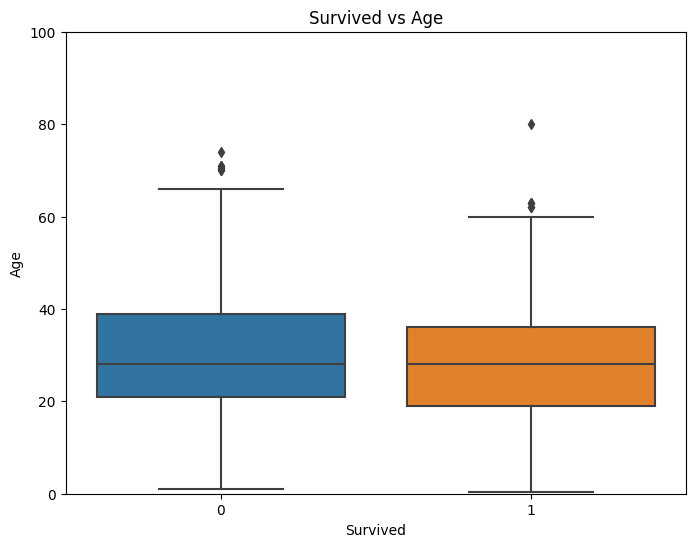

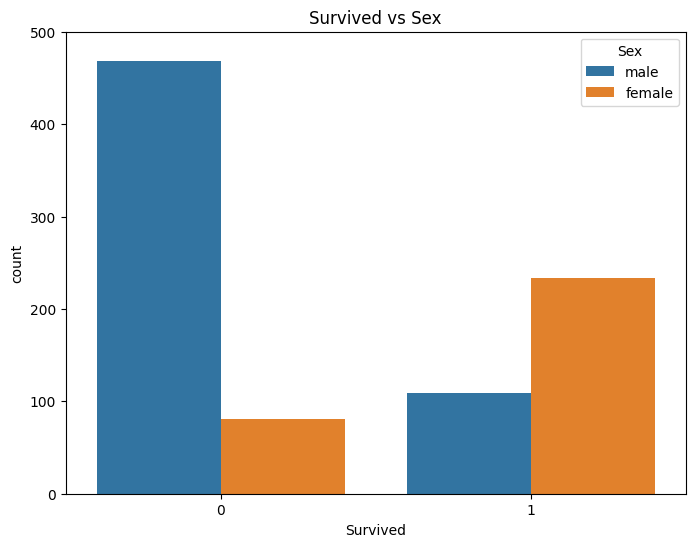

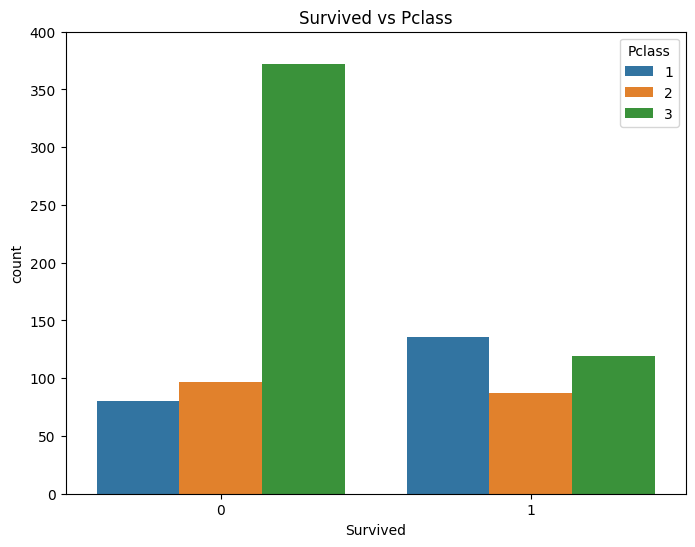

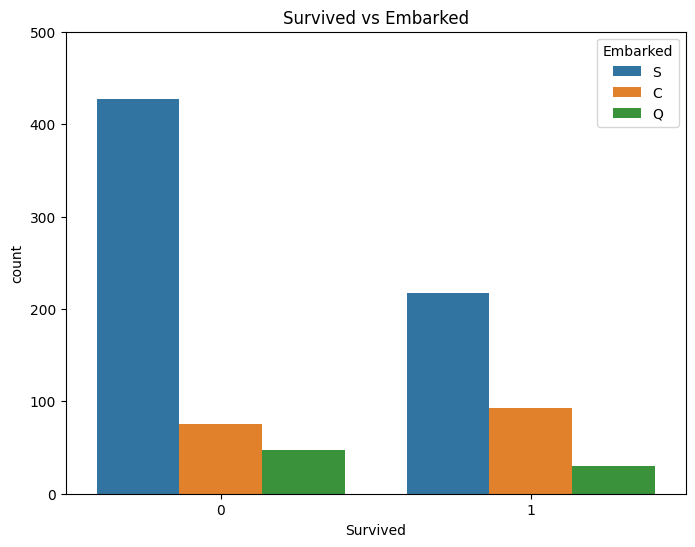

In [5]:
# Plot charts between multiple variables
# age
fig, ax=plt.subplots(1,figsize=(8,6))
sns.boxplot(x='Survived',y='Age', data=train)
ax.set_ylim(0,100)
plt.title("Survived vs Age")
plt.show()

# Sex
fig, ax=plt.subplots(1,figsize=(8,6))
sns.countplot(x='Survived' ,hue='Sex', data=train)
ax.set_ylim(0,500)
plt.title("Survived vs Sex")
plt.show()

# Pclass
fig, ax=plt.subplots(1,figsize=(8,6))
sns.countplot(x='Survived' ,hue='Pclass', data=train)
ax.set_ylim(0,400)
plt.title("Survived vs Pclass")
plt.show()

# Embarked
fig, ax=plt.subplots(1,figsize=(8,6))
sns.countplot(x='Survived' ,hue='Embarked', data=train)
ax.set_ylim(0,500)
plt.title("Survived vs Embarked")
plt.show()

## Insights from the charts:
- For Age, few points are located outside the whiskers of the box plot. However, since it is still within a reasonable age range (around 62 - 80 years old) we'll keep the data
- Females were more likely to survived than Male
- Upper-class passengers (Pclass = 1) were more likely to survived that crash
- Passengers embarked from S were less likely to survived (Possibility of a correlation between Pclass and Embarked)

## Additional insights:
- Since class of passengers is significant in predicting survivability, it might be worth trying to infer the social status of a passenger from his/her name
- Since a lof of the values are unique, dropping the 'PassengerId', 'Ticket' and the 'Cabin' columns might improve the accuracy of our model
- Might be worthwhile to combine 'SibSp' and 'Parch' columns to create 'FamilySize' column instead

In [6]:
# Drop PassengerId, Ticket and Cabin columns
train = train.drop(['PassengerId', 'Ticket', 'Cabin'], axis = 1)
test = test.drop(['Ticket', 'Cabin'], axis = 1)
combine = [train, test]

## Feature Engineering
1. Create FamilySize column from SibSp and Parch
2. Create Title column from Name
3. Encode all categorical columns except Embarked (has missing values)
4. Drop unnecessary columns

In [7]:
# Crate FamilySize column from SibSp and Parch
for df in combine:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

In [8]:
# Create Title column from Name
for df in combine:
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [9]:
# Replace titles to more common names and group rare titles
common = ['Master', 'Mr', 'Miss', 'Mrs']
for df in combine:
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = [x if x in common else 'Rare' for x in df['Title']]

train['Title'].value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64

In [10]:
# Encode columns
for df in combine:
    df['Sex'] = df['Sex'].map({'female': 0, 'male': 1})
    #df['Title'] = df['Title'].map({'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4})
    
title_ohe1 = pd.get_dummies(train['Title'], prefix = 'Title', drop_first = True)
train = pd.concat([train.drop('Title', axis = 1), title_ohe1], axis = 1)

title_ohe2 = pd.get_dummies(test['Title'], prefix = 'Title', drop_first = True)
test = pd.concat([test.drop('Title', axis = 1), title_ohe2], axis = 1)

In [11]:
# Drop Name, SibSp and Parch columns
train = train.drop(['Name', 'SibSp', 'Parch'], axis = 1)
test = test.drop(['Name', 'SibSp', 'Parch'], axis = 1)
combine = [train, test]

### Imputation : Age

In [12]:
# Check correlation of Age with other variables
age_corr = train.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
age_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
age_corr[age_corr['Feature 1'] == 'Age']

/var/folders/nl/l2b2vttd7j73mhvfwrp0lwzr0000gn/T/ipykernel_5942/1542552217.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  age_corr = train.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()


,Feature 1,Feature 2,Correlation Coefficient
7,Age,Age,1.000000
26,Age,Pclass,0.369226
37,Age,FamilySize,0.301914
38,Age,Title_Miss,0.277827
47,Age,Title_Mr,0.206341
50,Age,Title_Rare,0.194639
60,Age,Title_Mrs,0.178069
77,Age,Fare,0.096067
78,Age,Sex,0.093254
82,Age,Survived,0.077221


In [13]:
# Impute Age based on Pclass
impute_ages = np.zeros((2,3))
for df in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            impute_df = df[(df['Sex'] == i) & \
                                  (df['Pclass'] == j+1)]['Age'].dropna()
            impute_ages[i,j] = int(impute_df.median())
            
    for i in range(0, 2):
        for j in range(0, 3):
            df.loc[ (df.Age.isnull()) & (df.Sex == i) & (df.Pclass == j+1), 'Age'] = impute_ages[i,j]

### Imputation: Embarked

Check correlation between Embarked & Pclass



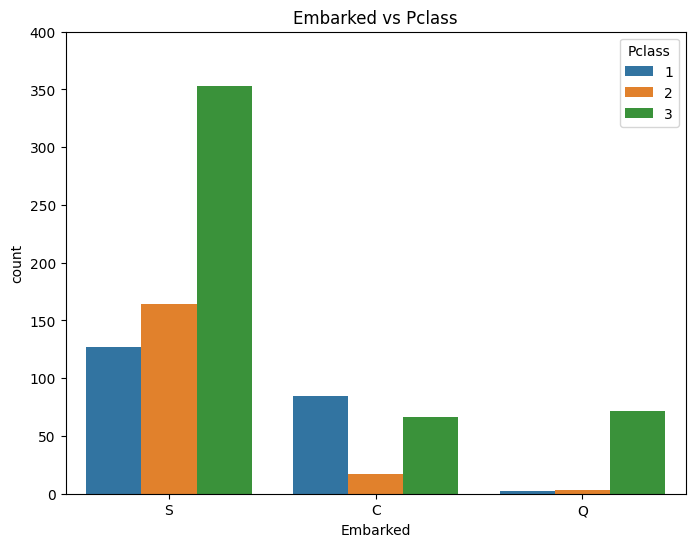

In [14]:
# Check correlation between Embarked & Pclass
fig, ax=plt.subplots(1,figsize=(8,6))
sns.countplot(x='Embarked',hue='Pclass', data=train)
ax.set_ylim(0,400)
plt.title("Embarked vs Pclass")
print('Check correlation between Embarked & Pclass\n')
plt.show()

There seem to be some correlation between Embarked and Pclass as lower-class passengers were more likely to embarked from S and most passengers that embarked from C were from the upper-class

In [15]:
impute_embarked= ['', '', '']
for df in combine:
    for i in range(0, 3):
        impute_val = df[df['Pclass'] == i+1]['Embarked'].dropna().mode()[0]
        impute_embarked[i] = impute_val
        
    for i in range(0, 3):
        df.loc[ (df.Embarked.isnull()) & (df.Pclass == i+1), 'Embarked'] = impute_embarked[i]

In [16]:
# for df in combine:
#     df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

embarked_ohe1 = pd.get_dummies(train['Embarked'], prefix = 'Embarked', drop_first = True)
train = pd.concat([train.drop('Embarked', axis = 1), embarked_ohe1], axis = 1)

embarked_ohe2 = pd.get_dummies(test['Embarked'], prefix = 'Embarked', drop_first = True)
test = pd.concat([test.drop('Embarked', axis = 1), embarked_ohe2], axis = 1)

combine = [train, test]

### Imputation: Fare

In [17]:
imputer = SimpleImputer()
test['Fare'] = list(imputer.fit_transform(test[['Fare']]))
test['Fare'] = [x[0] for x in test['Fare']]

# Check if there's any missing values left
print('Number of missing value(s) in every column (Train):')
print(train.isnull().sum())
print('Number of missing value(s) in every column (Test):')
print(test.isnull().sum())

Number of missing value(s) in every column (Train):
Survived      0
Pclass        0
Sex           0
Age           0
Fare          0
FamilySize    0
Title_Miss    0
Title_Mr      0
Title_Mrs     0
Title_Rare    0
Embarked_Q    0
Embarked_S    0
dtype: int64
Number of missing value(s) in every column (Test):
PassengerId    0
Pclass         0
Sex            0
Age            0
Fare           0
FamilySize     0
Title_Miss     0
Title_Mr       0
Title_Mrs      0
Title_Rare     0
Embarked_Q     0
Embarked_S     0
dtype: int64


# Modelling

In [18]:
# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

OSError: dlopen(/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: '/usr/local/opt/libomp/lib/libomp.dylib'
  Referenced from: '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/lightgbm/lib_lightgbm.so'
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file)

In [ ]:
X = train.drop(columns = 'Survived')
X = pd.get_dummies(X, drop_first = True)

y = train['Survived']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
def find_best_model(X_train, X_test, y_train, y_test):
    # Logistic Regression
    logreg = LogisticRegression(max_iter = 600, random_state = 42)
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    logreg_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # Decision Tree
    decision_tree = DecisionTreeClassifier(random_state = 42)
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)
    decision_tree_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # Random Forest
    random_forest = RandomForestClassifier(random_state = 42)
    random_forest.fit(X_train, y_train)
    y_pred = random_forest.predict(X_test)
    random_forest_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # XGBoost
    xgb = XGBClassifier(random_state = 42)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    xgb_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # GBM
    gbm = GradientBoostingClassifier(random_state = 42)
    gbm.fit(X_train, y_train)
    y_pred = gbm.predict(X_test)
    gbm_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # LightGBM
    lgbm = LGBMClassifier(random_state = 42)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    lgbm_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
        
    # Catboost
    catb = CatBoostClassifier(verbose = 0, random_state = 42)
    catb.fit(X_train, y_train)
    y_pred = catb.predict(X_test)
    catb_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    # Histogram-based Gradient Boosting Classification Tree
    hgb = HistGradientBoostingClassifier(random_state = 42)
    hgb.fit(X_train, y_train)
    y_pred = hgb.predict(X_test)
    hgb_acc = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
    
    model_df = pd.DataFrame({'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'GBM', 'LightGBM', 'Catboost', 'HistBoost'],
                       'Score': [logreg_acc, decision_tree_acc, random_forest_acc, xgb_acc, gbm_acc, lgbm_acc, catb_acc, hgb_acc]})
    print(model_df.sort_values('Score', ascending = False).reset_index(drop = True))

In [ ]:
find_best_model(X_train, X_test, y_train, y_test)

Our Random Forest model performed the best on unseen data.

# Random Forest
Find the best hyperparameters for our Random Forest model using GridSearch and fit it accoring to those parameters.

In [ ]:
rfc = RandomForestClassifier(random_state=42, 
                             n_jobs=-1 # Use all cores on your machine
                            )
param_grid = { 
    'n_estimators': [100, 200, 300], # The number of boosting stages to perform
    'max_features': ['auto'], # The number of features to consider when looking for the best split
    'max_depth' : [4, 6, 8], # The maximum depth of the individual regression estimators.
    'criterion' :['gini', 'entropy'] #Function to measure the quality of a split
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring = 'accuracy', verbose = 10)
CV_rfc.fit(X, y)
print('')
print('Best hyperparameters:',CV_rfc.best_params_)

X_test = test.drop('PassengerId', axis = 1)
predictions = CV_rfc.predict(X_test)

output = pd.DataFrame({'PassengerId': test.PassengerId,
                      'Survived': predictions})

output.to_csv('titanic-submission.csv', index= False)